In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
import tensorflow as tf
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl

# macOS下中文字体需要额外设置，Windows下注意字体路径不同
zhfont=mpl.font_manager.FontProperties(fname="/System/Library/Fonts/Supplemental/Songti.ttc")
# zhfont=mpl.font_manager.FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc")

# 读取数据，先做归一化，其他归一化excel里做了，这个忘了
df = pd.read_csv('data.csv')
scaler = MinMaxScaler()
x_list = np.array(list(df['lbc_count']))
xx = x_list.reshape((-1,1),order='F')
x_list = scaler.fit_transform(xx)
df['std_lbc_count'] = x_list


# 制作数据集，用过去7天预测14天后的情况，x_all不含非时序特征，x/y_train/test含非时序特征
x_all = []
y_all = []
o_all = []
d_all = []
de_all = []
week_all =[]
window_size = 7

x_list = np.array(list(df['std_lbc_count']))
x_list = x_list.reshape((-1,1),order='F')
len_train = int(x_list.shape[0])
for i in range(len_train - window_size - 14):
    x_all.append(x_list[i:i+window_size])
    y_all.append(x_list[i+window_size+14])
    o_all.append(df['O_std'][i])
    d_all.append(df['D_std'][i])
    de_all.append(df['de_std'][i])
    week_all.append(df['week_std'][i])

# 由于LSTM隐藏层输出的是float32，而数据是float64，为保证能一起进入最后的BP网络，需要手动将非时序特征调整为float32
x_all = np.array(x_all)
y_all = np.array(y_all)
x_all = np.array(x_all)
y_all = np.array(y_all)
o_all = np.array(o_all).astype(np.float32)
d_all = np.array(d_all).astype(np.float32)
de_all = np.array(de_all).astype(np.float32)
week_all = np.array(week_all).astype(np.float32)

# 手动分割训练集和测试集，由于是预测问题，测试集合设定为最后的30%，分别准备包含非时序特征和不包含非时序特征的数据集
x_train = [x_all[:645],o_all[:645],d_all[:645],de_all[:645],week_all[:645]]
x_train_2 = x_all[:645]
y_train = y_all[:645]
x_test = [x_all[645:],o_all[645:],d_all[645:],de_all[645:],week_all[645:]]
x_test_2 = x_all[645:]
y_test = y_all[645:]

In [3]:
# 建立完整的Attention模型
class ELSTMModel(Model):
    def __init__(self):
        super(ELSTMModel, self).__init__()
        self.lstm = tf.keras.layers.LSTM(32,return_sequences=True)
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.Sout1 = tf.keras.layers.Dense(1, activation='relu')
        self.dense2 = tf.keras.layers.Dense(128, activation='relu')
        self.out = tf.keras.layers.Dense(1, activation='relu')
        self.rv = tf.keras.layers.RepeatVector(7)
    def call(self, x):
        # 读取时序特征，并经过一个完整的LSTM模型
        t = x[0]
        x1 = self.lstm(t)
        O = self.rv(tf.expand_dims(x[1], axis=-1))
        D = self.rv(tf.expand_dims(x[2], axis=-1))
        DE = self.rv(tf.expand_dims(x[3], axis=-1))
        WEEK = self.rv(tf.expand_dims(x[4], axis=-1))
        # 重整输入，将非时序特征引入，并经过Attention Dense Layer
        x2 = tf.concat([x1,O,D,DE,WEEK],2)
        x2 = self.dense2(x2)
        out = self.Sout1(x2)
        out = tf.reshape(out,[-1,7])
        out = self.out(out)
        return out


# 实例化自定义的模型，并确定训练方式，由于模型比较复杂，使用Gradient Tape调试模式训练
LSTM_model = ELSTMModel()
lossf = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

@tf.function
def train(x, labels):
    with tf.GradientTape() as tape:
        predictions = LSTM_model(x, training=True)
        loss = lossf(labels, predictions)
    gradients = tape.gradient(loss, LSTM_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, LSTM_model.trainable_variables))
    train_loss(loss)

@tf.function
def test_step(x, labels):
    predictions = LSTM_model(x, training=False)
    t_loss = lossf(labels, predictions)
    test_loss(t_loss)

# 训练100次
train_loss_LIST = []
test_loss_LIST = []
for i in range(100):
    train_loss.reset_states()
    train(x_train,y_train)
    test_step(x_test,y_test)
    train_loss_LIST.append(train_loss.result())
    test_loss_LIST.append(test_loss.result())

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-06-09 13:54:14.136193: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-09 13:54:14.136342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-09 13:54:14.596824: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-09 13:54:14.599480: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-09 13:54:14.601070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 13:54:14.668400: I tensorflow/core/grappler/

In [4]:
# 建立两步走的Attention模型
class ALSTMModel(Model):
    def __init__(self):
        super(ALSTMModel, self).__init__()
        self.lstm = tf.keras.layers.LSTM(32, return_sequences=True)
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.Sout1 = tf.keras.layers.Dense(1, activation='relu')
        self.dense2 = tf.keras.layers.Dense(128, activation='relu')
        self.out = tf.keras.layers.Dense(1, activation='relu')
    def call(self, x):
        # 读取时序特征，并经过一个完整的LSTM模型
        t = x[0]
        x1 = self.lstm(t)
        x1 = self.dense1(x1)
        x1 = self.Sout1(x1)
        x1 = tf.reshape(x1,[-1,7])
        O = tf.expand_dims(x[1], axis=-1)
        D = tf.expand_dims(x[2], axis=-1)
        DE = tf.expand_dims(x[3], axis=-1)
        WEEK = tf.expand_dims(x[4], axis=-1)
        # 重整输入，将非时序特征引入，并经过BP神经网络
        x2 = tf.concat([x1,O,D,DE,WEEK],1)
        x2 = self.dense2(x2)
        out = self.out(x2)
        return out

# 实例化自定义的模型，并确定训练方式，由于模型比较复杂，使用Gradient Tape调试模式训练
ALSTM_model = ALSTMModel()
lossf = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

@tf.function
def train_A(x, labels):
    with tf.GradientTape() as tape:
        predictions = ALSTM_model(x, training=True)
        loss = lossf(labels, predictions)
    gradients = tape.gradient(loss, ALSTM_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, ALSTM_model.trainable_variables))
    train_loss(loss)

@tf.function
def test_step_A(x, labels):
    predictions = ALSTM_model(x, training=False)
    t_loss = lossf(labels, predictions)
    test_loss(t_loss)

# 训练100次
train_loss_LIST_A = []
test_loss_LIST_A = []
for i in range(100):
    train_loss.reset_states()
    train_A(x_train,y_train)
    test_step_A(x_test,y_test)
    train_loss_LIST_A.append(train_loss.result())
    test_loss_LIST_A.append(test_loss.result())

2022-06-09 13:54:16.873732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 13:54:16.933886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 13:54:16.993323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 13:54:17.214198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 13:54:17.238534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [5]:
GRU_model = tf.keras.models.Sequential([
            tf.keras.layers.GRU(64),
            tf.keras.layers.Dense(1)
            ])
GRU_model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])
GRU_model.build(input_shape=(None,7,1)) 

lossf = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

@tf.function
def train_G(x, labels):
    with tf.GradientTape() as tape:
        predictions = GRU_model(x, training=True)
        loss = lossf(labels, predictions)
    gradients = tape.gradient(loss, GRU_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, GRU_model.trainable_variables))
    train_loss(loss)

@tf.function
def test_step_G(x, labels):
    predictions = GRU_model(x, training=False)
    t_loss = lossf(labels, predictions)
    test_loss(t_loss)

# 训练100次
train_loss_LIST_G = []
test_loss_LIST_G = []
for i in range(100):
    train_loss.reset_states()
    train_G(x_train_2,y_train)
    test_step_G(x_test_2,y_test)
    train_loss_LIST_G.append(train_loss.result())
    test_loss_LIST_G.append(test_loss.result())

2022-06-09 13:54:19.094716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 13:54:19.140641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 13:54:19.173889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 13:54:19.316553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 13:54:19.333825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [6]:
LSTM_2_model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(64),
            tf.keras.layers.Dense(1)
            ])
LSTM_2_model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])
LSTM_2_model.build(input_shape=(None,7,1))

lossf = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

@tf.function
def train_L(x, labels):
    with tf.GradientTape() as tape:
        predictions = LSTM_2_model(x, training=True)
        loss = lossf(labels, predictions)
    gradients = tape.gradient(loss, LSTM_2_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, LSTM_2_model.trainable_variables))
    train_loss(loss)

@tf.function
def test_step_L(x, labels):
    predictions = LSTM_2_model(x, training=False)
    t_loss = lossf(labels, predictions)
    test_loss(t_loss)

# 训练100次
train_loss_LIST_L = []
test_loss_LIST_L = []
for i in range(100):
    train_loss.reset_states()
    train_L(x_train_2,y_train)
    test_step_L(x_test_2,y_test)
    train_loss_LIST_L.append(train_loss.result())
    test_loss_LIST_L.append(test_loss.result())

2022-06-09 13:54:20.700442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 13:54:20.749454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 13:54:20.783666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 13:54:20.922895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-06-09 13:54:20.942233: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


tf.Tensor(0.028190069, shape=(), dtype=float32)
tf.Tensor(0.0345398, shape=(), dtype=float32)
tf.Tensor(0.044466212, shape=(), dtype=float32)
tf.Tensor(0.045439288, shape=(), dtype=float32)


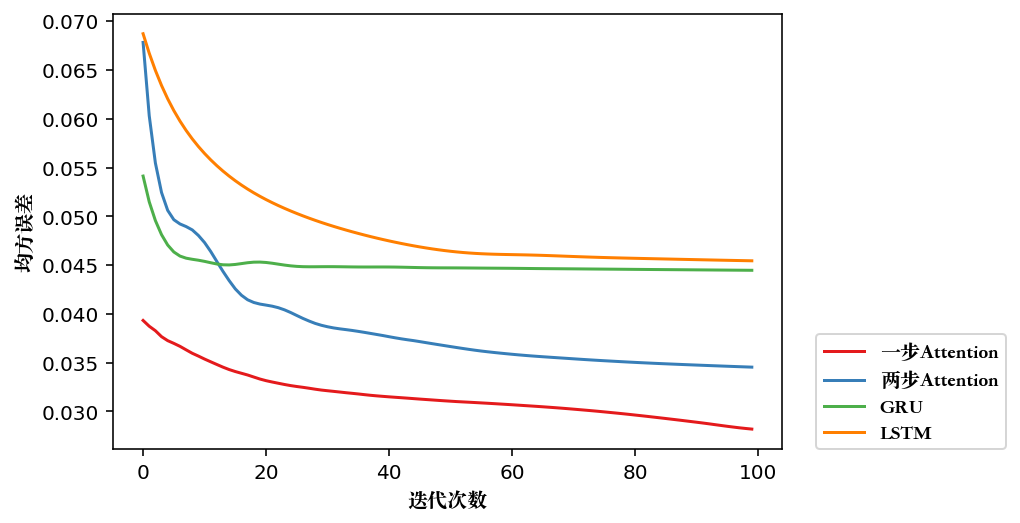

In [7]:
# 可视化图2和表3中的数据
plt.figure()
plt.xlabel('迭代次数',fontproperties=zhfont)
plt.ylabel('均方误差',fontproperties=zhfont)

plt.plot(range(100), train_loss_LIST , color = plt.get_cmap('Set1')(0), label='一步Attention')
# 打印最后一轮的训练和测试集的损失
print(train_loss_LIST[99])

plt.plot(range(100), train_loss_LIST_A , color = plt.get_cmap('Set1')(1), label='两步Attention')
# 打印最后一轮的训练和测试集的损失
print(train_loss_LIST_A[99])

plt.plot(range(100), train_loss_LIST_G , color = plt.get_cmap('Set1')(2), label='GRU')
# 打印最后一轮的训练和测试集的损失
print(train_loss_LIST_G[99])

plt.plot(range(100), train_loss_LIST_L , color = plt.get_cmap('Set1')(4), label='LSTM')
# 打印最后一轮的训练和测试集的损失
print(train_loss_LIST_L[99])

plt.legend(prop=zhfont,bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.savefig('r_trainset.png')
plt.show()

tf.Tensor(0.048765335, shape=(), dtype=float32)
tf.Tensor(0.056642156, shape=(), dtype=float32)
tf.Tensor(0.061886005, shape=(), dtype=float32)
tf.Tensor(0.06454667, shape=(), dtype=float32)


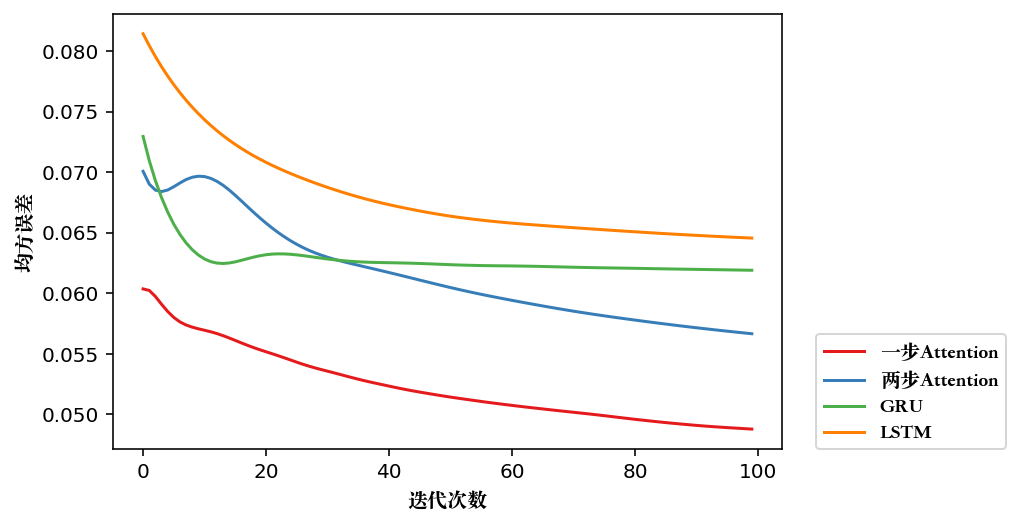

In [8]:
# 可视化图2和表3中的数据
plt.figure()
plt.xlabel('迭代次数',fontproperties=zhfont)
plt.ylabel('均方误差',fontproperties=zhfont)

plt.plot(range(100), test_loss_LIST , color = plt.get_cmap('Set1')(0), label='一步Attention')
# 打印最后一轮的训练和测试集的损失
print(test_loss_LIST[99])

plt.plot(range(100), test_loss_LIST_A , color = plt.get_cmap('Set1')(1), label='两步Attention')
# 打印最后一轮的训练和测试集的损失
print(test_loss_LIST_A[99])

plt.plot(range(100), test_loss_LIST_G , color = plt.get_cmap('Set1')(2), label='GRU')
# 打印最后一轮的训练和测试集的损失
print(test_loss_LIST_G[99])

plt.plot(range(100), test_loss_LIST_L , color = plt.get_cmap('Set1')(4), label='LSTM')
# 打印最后一轮的训练和测试集的损失
print(test_loss_LIST_L[99])

plt.legend(prop=zhfont,bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0)
plt.savefig('r_testset.png')
plt.show()